In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from cnnlearning import *
from learningutils import *
from patchextraction import *
from imageprosessing import *
from nearest_neighbors import *
from evaluation import *
from classificationutils import *
from sharedvariables import get_video_sessions
from vesseldetection import *
from generate_datasets import *
from guitools import CvRoipolySelector, CvPointSelector
from plotutils import no_ticks, savefig_tight
from vesseldetection import binarize_vessel_image, create_vessel_mask_from_frames

import os
import pathlib
plt.rcParams['image.cmap'] = 'gray'

# Jupyter Notebook settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%autosave 5
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Imports for data analysis
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 2000)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# size=25
size=35
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

video_sessions = get_video_sessions(registered=True, marked=True)
vs = video_sessions[0]

[vs.basename for vs in video_sessions]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 5 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped',
 'Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped',
 'Subject47_Session375_OD_(0,-1)_1.04x1.04_3056_OA790nm1_extract_reg_cropped',
 'Subject48_Session379_OD_(-10,0)_1.04x1.04_3111_OA790nm1_extract_reg_cropped',
 'Subject48_Session379_OD_(-7,-2)_1.04x1.04_3107_OA790nm1_extract_reg_cropped',
 'Subject52_Session404_OD_(0,-3)_1.04x1.04_3466_OA790nm1_extract_reg_cropped',
 'Subject52_Session404_OD_(0,-4)_1.04x1.04_3465_OA790nm1_extract_reg_cropped',
 'Subject52_Session408_OD_(0,-5)_1.04x1.04_3576_OA790nm1_extract_reg_cropped']

In [8]:
def create_report_results(vs, std_img=None, exposure_iterations=1):
    plt.rcParams['font.size'] = 23
    plt.rcParams['axes.titlesize'] = 23
    plt.rcParams['figure.titlesize'] = 23
    
    ouptut_dir = os.path.join('tmp', 'figures', os.path.splitext(os.path.basename(vs.video_file))[0])
    pathlib.Path(ouptut_dir).mkdir(parents=True, exist_ok=True)
    file_prefix = os.path.join(ouptut_dir, 'im')
    print('file_prefix ', file_prefix)
    
    plt.imshow(vs.masked_frames_oa790.std(0).filled(vs.masked_frames_oa790.std(0).mean()))
    plt.title('Standard deviation image')
    no_ticks()
    savefig_tight(f'{file_prefix}_0.png')
    
    ### ### #### Create vessel image
    frames = enhance_motion_contrast_de_castro(vs.masked_frames_oa790, sigma=0)
    plt.imshow(frames.std(0).filled(frames.std(0).mean()))
    plt.title('Standard deviation image after de castro', fontdict={'size': 15})
    savefig_tight(f'{file_prefix}_1.png')
    
    from vesseldetection import create_vessel_image_from_frames
    vessel_image_with_de_castro = std_img
    if vessel_image_with_de_castro is None:
        vessel_image_with_de_castro = create_vessel_image_from_frames(vs.masked_frames_oa790, de_castro=True)
    
    no_ticks()
    plt.imshow(vessel_image_with_de_castro)
    plt.title('Standard deviation image after video motion contrast enhancement', fontdict={'size': 15})
    savefig_tight(f'{file_prefix}_2.png')
    
    vessel_image = vessel_image_with_de_castro.copy()
    
    ### ### #### Increase vessel image contrast
    normalise_fangi=False
    equalize_frangi_hist=True

    threshold_sensitivity=0.5

    opening_kernel_size=7
    closing_kernel_size=15
    padding=cv2.BORDER_REPLICATE
    padding_size=30
    padding_value=None

    visualise_intermediate_steps=False
    vessel_image = cv2.copyMakeBorder(vessel_image,
                                  padding_size,
                                  padding_size,
                                  padding_size,
                                  padding_size,
                                  padding)

    not_enough_vessel_regions_found = True

    vessel_image_contrast_enhanced = vessel_image.copy()

    # exposure iterations increase as long as not enough vessel regions are found, until at least one vessel
    # region is found.
    for _ in range(exposure_iterations):
        sigma = 1.4
        if sigma > 0:
            vessel_image_contrast_enhanced = skimage.filters.gaussian(vessel_image_contrast_enhanced, sigma=sigma)
        vessel_image_contrast_enhanced = skimage.exposure.equalize_adapthist(vessel_image_contrast_enhanced)

    no_ticks()
    plt.imshow(vessel_image_contrast_enhanced[padding_size:-padding_size, padding_size:-padding_size])
    plt.title('Contrast enhanced')
    savefig_tight(f'{file_prefix}_3.png')
    
    #### #### ####
    frangi_image = skimage.filters.frangi(vessel_image_contrast_enhanced, alpha=.5, beta=.5, black_ridges=False)

    normalise_fangi = True

    if equalize_frangi_hist:
        frangi_image = skimage.exposure.equalize_adapthist(frangi_image)

    if normalise_fangi:
        frangi_image = cv2.normalize(frangi_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    plt.figure()
    no_ticks()
    plt.imshow(frangi_image[padding_size:-padding_size, padding_size:-padding_size], cmap='hot')
    plt.title('Frangi image')
    savefig_tight(f'{file_prefix}_4.png')
    
    #### #### ####
    binary_threshold = skimage.filters.threshold_otsu(frangi_image, nbins=256)
    BW = np.zeros_like(frangi_image)
    BW[frangi_image > binary_threshold * threshold_sensitivity] = 1
    BW = np.uint8(BW)

    plt.figure()
    no_ticks()
    plt.title('Binary image')
    plt.imshow(BW[padding_size:-padding_size, 
                  padding_size:-padding_size])
    savefig_tight(f'{file_prefix}_5.png')
    
    #### ##### ####
    # Opening get's rid of small specles
    opening_kernel = morphology.disk(5)
    opening = cv2.morphologyEx(BW, cv2.MORPH_OPEN, opening_kernel)

    plt.figure()
    no_ticks()
    plt.imshow(opening[padding_size:-padding_size, 
                       padding_size:-padding_size])
    plt.title('Binary opening')
    savefig_tight(f'{file_prefix}_6.png')
    #### ##### #####
    # Closing connects components
    closing_kernel = morphology.disk(9)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, closing_kernel)
    closing = skimage.morphology.area_closing(closing, 200)

    plt.figure()
    no_ticks()
    plt.imshow(closing[padding_size:-padding_size, 
                       padding_size:-padding_size])
    plt.title('Binary closing')
    savefig_tight(f'{file_prefix}_7.png')
    
    dilation_iterations = 4
    for _ in range(dilation_iterations):
        closing = skimage.morphology.binary_dilation(closing)
        
    plt.figure()
    no_ticks()
    plt.imshow(closing[padding_size:-padding_size, 
                       padding_size:-padding_size])
    plt.title('Binary dilation')
    savefig_tight(f'{file_prefix}_8.png')
    #### #### ####
    
    vessel_mask = closing[padding_size:-padding_size, padding_size:-padding_size]
    #     plt.imshow(vessel_mask)
    vessel_mask[:, :20] = 0
    vessel_mask[:, -20:] = 0

    #     plt.imshow(vessel_mask)

    vessel_mask = np.bool8(vessel_mask)
    labeled_image = measure.label(vessel_mask)
    region_props = measure.regionprops(labeled_image)

    region_areas = np.array([prop.area for prop in region_props])
    region_areas = np.delete(region_areas, np.argmax(region_areas))
    
    plt.figure()
    no_ticks()
    plt.imshow(labeled_image)
    plt.title('labeled image')
    #### #### ####
    _, ax = plt.subplots()
    no_ticks(np.array(ax))
    ax.imshow(vessel_mask)

    region_areas = np.flip(np.sort(region_areas))[:min(len(region_areas), 7)]
    area_mean = region_areas.mean()

    min_area = 700
    for region in region_props:
        if region.area < min_area:
            minr, minc, maxr, maxc = region.bbox
            rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
    ax.set_title('Removing small area regions')
    final_vessel_mask = morphology.remove_small_objects(vessel_mask, min_area)
    savefig_tight(f'{file_prefix}_9.png')
    
    plt.figure()
    plt.imshow(final_vessel_mask)
    no_ticks()
    plt.title('Vessel mask')
    savefig_tight(f'{file_prefix}_10.png')
    
    plt.figure()
    no_ticks()
    plt.imshow(vessel_image_contrast_enhanced[padding_size:-padding_size, padding_size:-padding_size] * final_vessel_mask)
    plt.title('Vessel mask')
    savefig_tight(f'{file_prefix}_11.png')

file_prefix  tmp\figures\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped\im
Saved  tmp\figures\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped\im_0.png
Saved  tmp\figures\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped\im_1.png
Saved  tmp\figures\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped\im_2.png
Saved  tmp\figures\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped\im_3.png
Saved  tmp\figures\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped\im_4.png
Saved  tmp\figures\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped\im_5.png
Saved  tmp\figures\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped\im_6.png
Saved  tmp\figures\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped\im_7.png
Saved  tmp\figures\

'Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped'

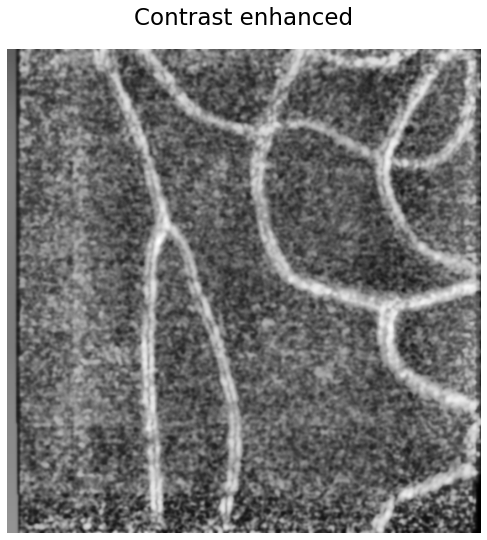

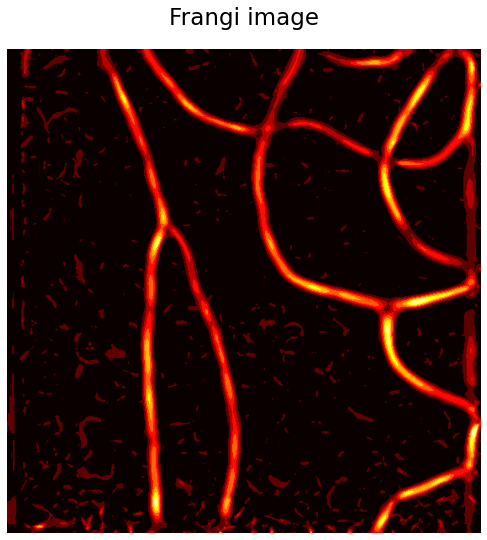

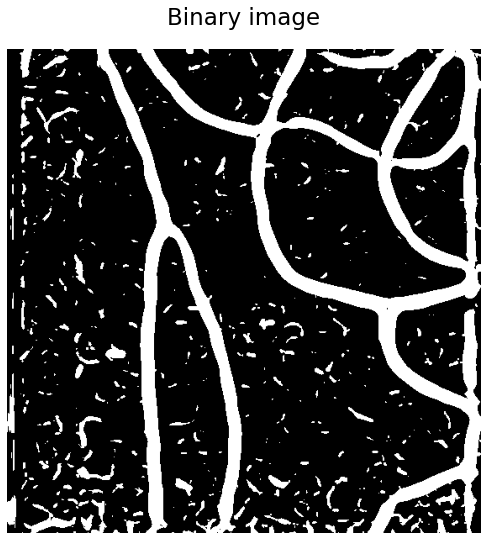

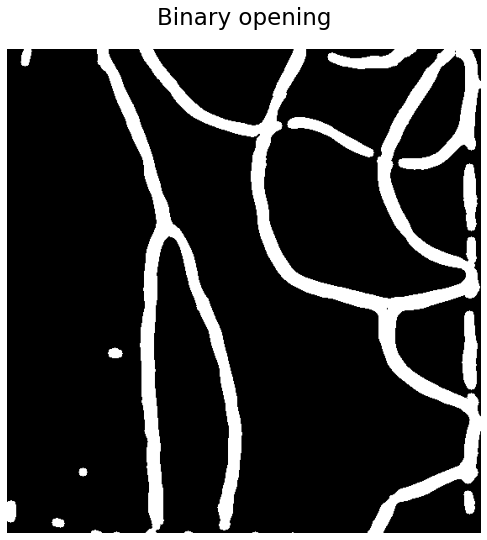

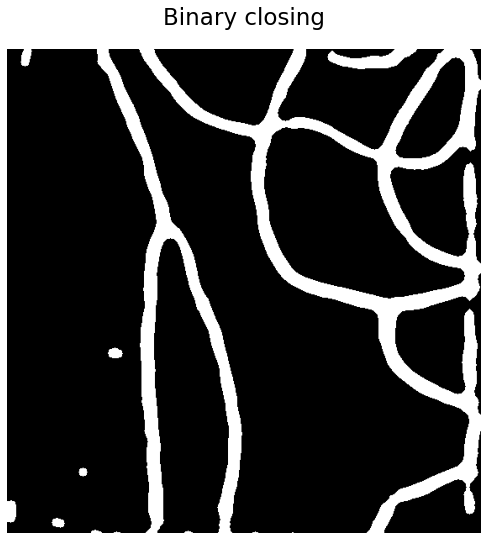

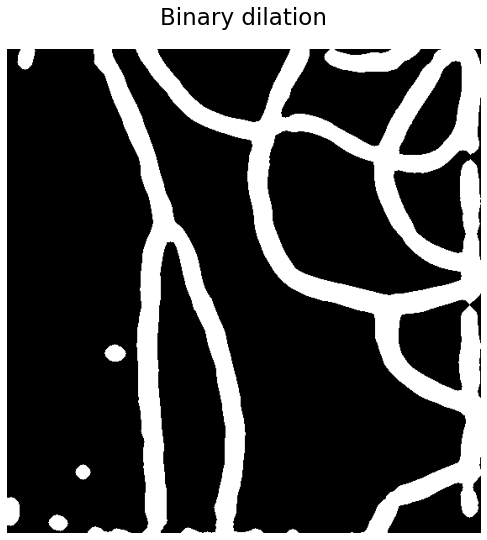

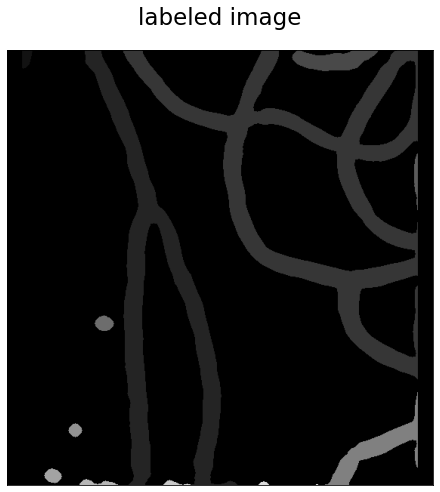

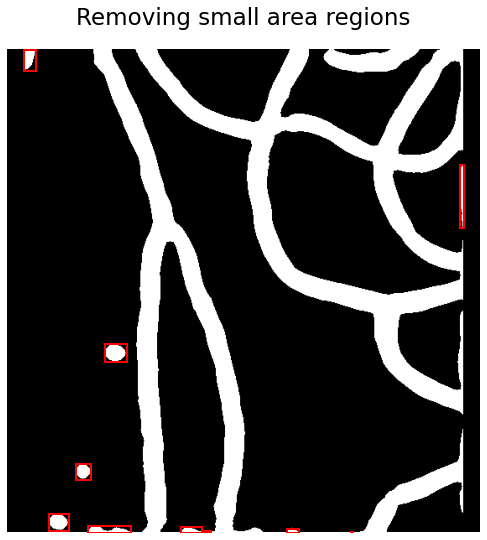

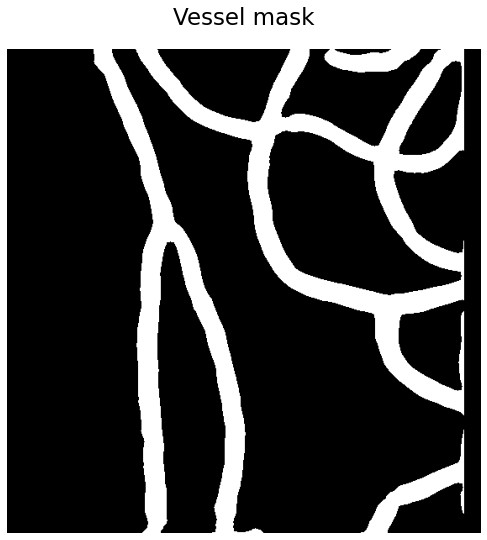

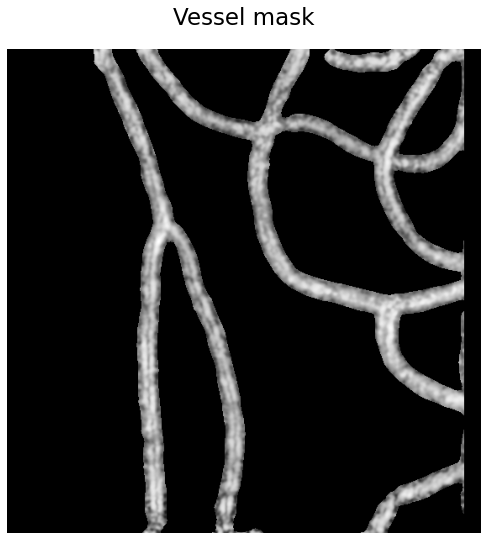

In [9]:
vessel_image = create_report_results(video_sessions[0])
video_sessions[0].basename

file_prefix  tmp\figures\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped\im
Saved  tmp\figures\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped\im_0.png
Saved  tmp\figures\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped\im_1.png
Saved  tmp\figures\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped\im_2.png
Saved  tmp\figures\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped\im_3.png
Saved  tmp\figures\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped\im_4.png
Saved  tmp\figures\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped\im_5.png
Saved  tmp\figures\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped\im_6.png
Saved  tmp\figures\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped\im_7.png
Saved  tmp\figures\Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1

'Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped'

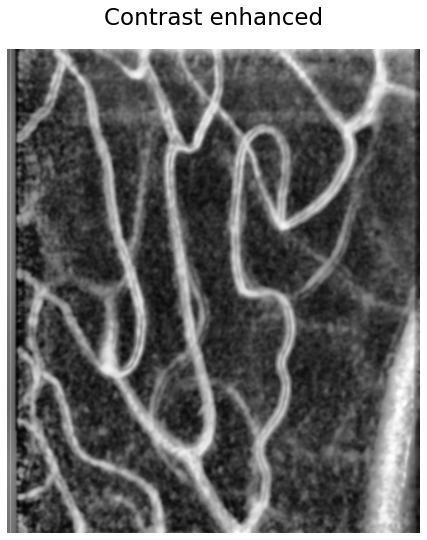

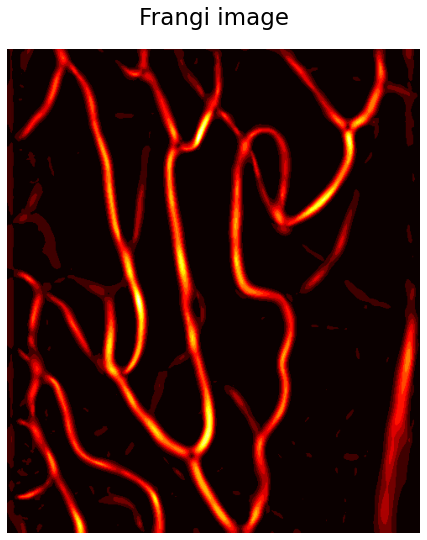

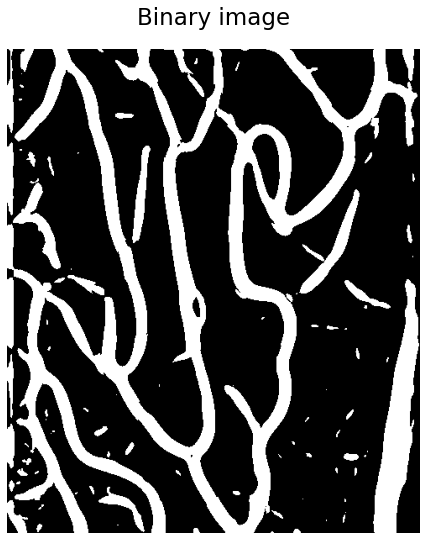

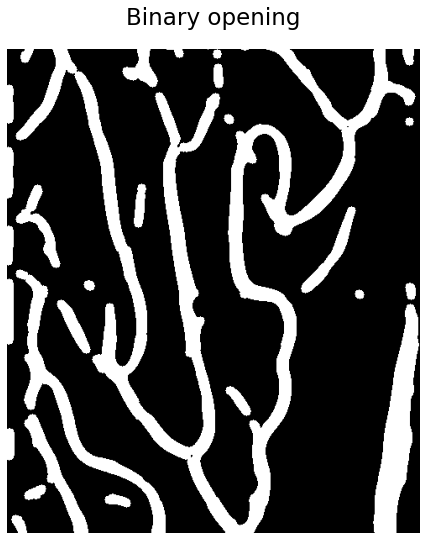

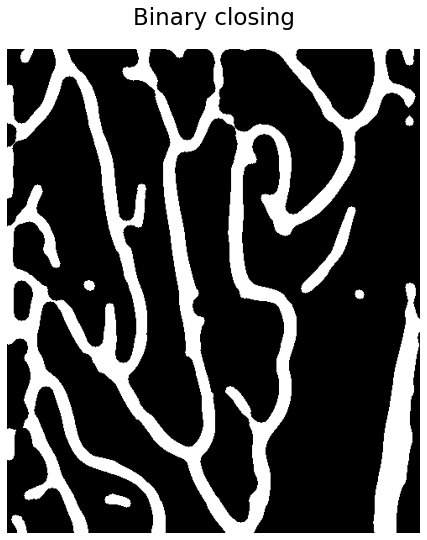

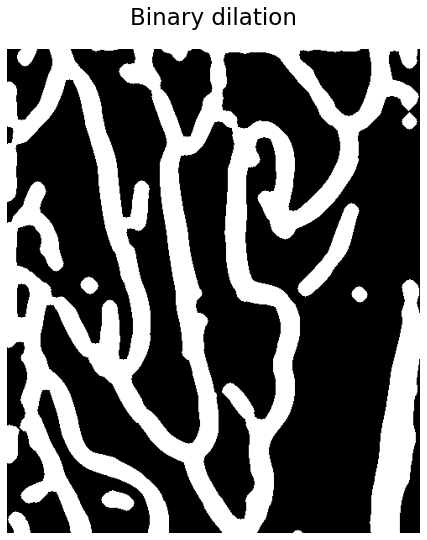

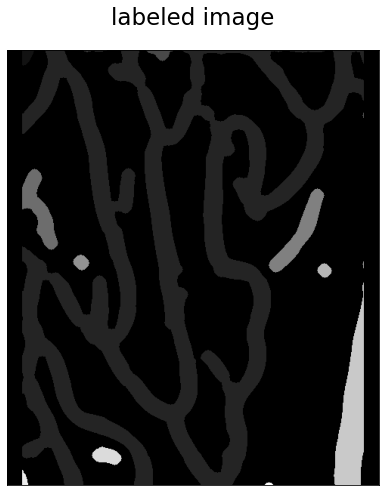

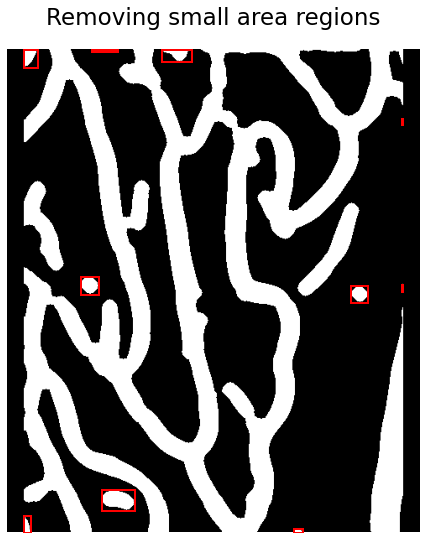

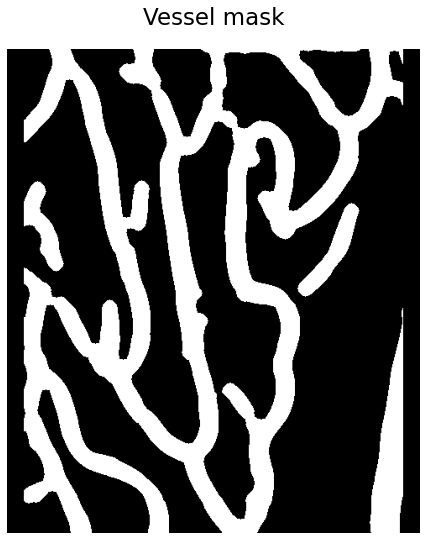

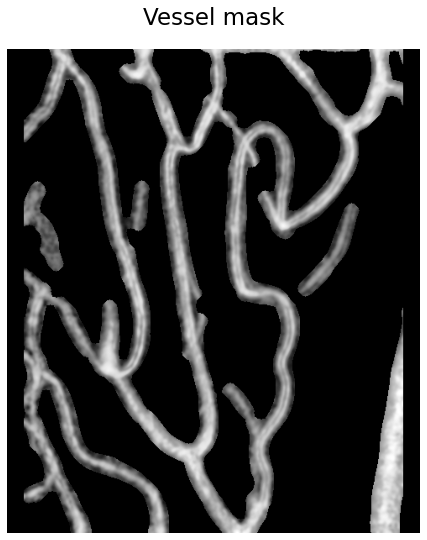

In [10]:
vessel_image = create_report_results(video_sessions[1])
video_sessions[1].basename

file_prefix  tmp\figures\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped\im
Saved  tmp\figures\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped\im_0.png
Saved  tmp\figures\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped\im_1.png
Saved  tmp\figures\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped\im_2.png
Saved  tmp\figures\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped\im_3.png
Saved  tmp\figures\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped\im_4.png
Saved  tmp\figures\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped\im_5.png
Saved  tmp\figures\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped\im_6.png
Saved  tmp\figures\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped\im_7.png
Saved  tmp\figures\Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped\im_8.png
Saved  tmp\figures\Subject3_Session216_OD_(0,0)_1x1_980_OA79

'Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped'

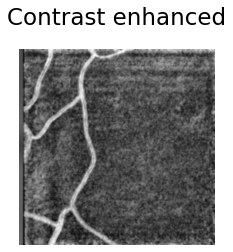

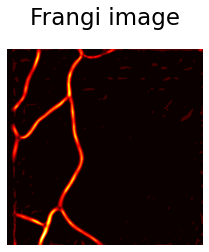

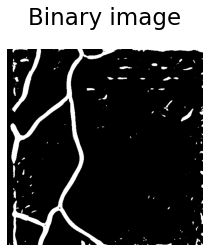

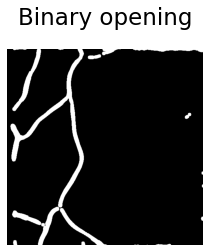

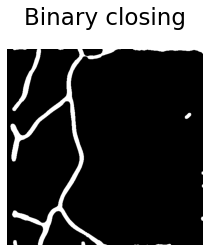

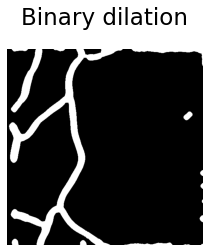

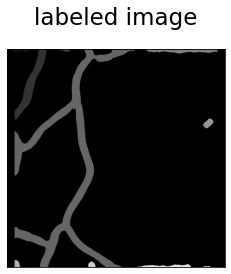

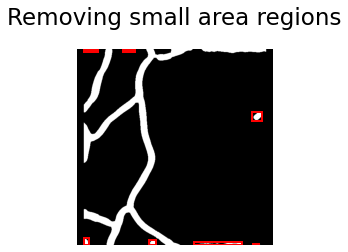

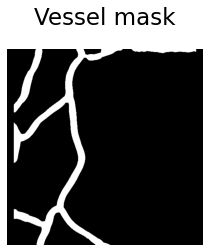

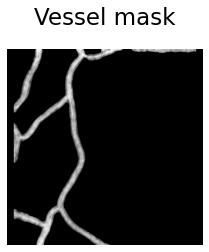

In [6]:
vessel_image = create_report_results(video_sessions[2])
video_sessions[2].basename